In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import collections

## Load the JupyterHub logs

In [2]:
columns = ['user', 'machine', 'session_start', 'session_end', 'session_length', 'log_file']

In [3]:
df_all = pd.read_csv("../data/jhub_logs.csv.gz", parse_dates=["session_start", "session_end"])
df_all["session_length"] = (df_all.session_end - df_all.session_start).dt.total_seconds().div(60)
df_all = df_all[columns]
df_all.head()

,user,machine,session_start,session_end,session_length,log_file
0,f1254b5ea30355edfb16,casper,2019-05-21 16:49:20,2019-05-21 17:17:25,28.083333,afd7c127fde74d8bb942
1,305f28fcefb86a65334a,casper,2019-06-02 22:09:49,2019-06-03 00:09:55,120.100000,068a0aa8476ce894b1ca
2,69bf308be7d4b41173fc,casper,2019-06-03 11:28:32,2019-06-03 13:28:53,120.350000,b73d381f256c774f760f
3,69bf308be7d4b41173fc,cheyenne,2019-06-03 13:38:34,2019-06-03 15:14:11,95.616667,f78266294c004fa22440
4,69bf308be7d4b41173fc,cheyenne,2019-06-04 09:40:50,2019-06-04 09:51:28,10.633333,f80f8e0000937dd3a4b6


In [4]:
df_all["machine"].unique()

array(['casper', 'cheyenne'], dtype=object)

In [5]:
dfs = collections.OrderedDict()
dfs['Cheyenne'] = df_all[df_all["machine"] == 'cheyenne']
dfs['Casper'] = df_all[df_all["machine"] == 'casper']
dfs['all'] =  df_all

## Basic Statistics

Some basic statistics from the logs.

In [6]:
print(f'Total number of sessions:')
for name in dfs:
    print(f'{name.rjust(10)}:   {len(dfs[name])}')

Total number of sessions:
  Cheyenne:   20653
    Casper:   24975
       all:   45628


In [7]:
def print_span(name):
    print(f'Total span of {name} logs:  {dfs[name].session_end.max() - dfs[name].session_start.min()}')
    print(f'   From: {dfs[name].session_start.min()}')
    print(f'   To:   {dfs[name].session_end.max()}')

for name in dfs:
    print_span(name)
    print()

Total span of Cheyenne logs:  988 days 20:29:47
   From: 2019-06-03 13:38:34
   To:   2022-02-16 10:08:21

Total span of Casper logs:  1001 days 17:55:30
   From: 2019-05-21 16:49:20
   To:   2022-02-16 10:44:50

Total span of all logs:  1001 days 17:55:30
   From: 2019-05-21 16:49:20
   To:   2022-02-16 10:44:50



In [8]:
def print_lengths(name):
    print(f'Session Lengths on {name} [minutes]:')
    print(f'   Minimum:  {dfs[name].session_length.min()}')
    print(f'   Maximum:  {dfs[name].session_length.max()}')
    print(f'   Mean:     {dfs[name].session_length.mean()}')
    print(f'   Median:   {dfs[name].session_length.median()}')

for name in dfs:
    print_lengths(name)
    print()

Session Lengths on Cheyenne [minutes]:
   Minimum:  0.0
   Maximum:  8075.883333333334
   Mean:     162.51485901967433
   Median:   120.18333333333334

Session Lengths on Casper [minutes]:
   Minimum:  0.0
   Maximum:  43202.0
   Mean:     895.9851865198533
   Median:   119.28333333333333

Session Lengths on all [minutes]:
   Minimum:  0.0
   Maximum:  43202.0
   Mean:     563.988108544461
   Median:   120.13333333333334



In [9]:
print(f'Total Number of Unique Users:')
for name in dfs:
    print(f'{name.rjust(10)}:   {dfs[name].user.nunique()}')

Total Number of Unique Users:
  Cheyenne:   417
    Casper:   463
       all:   599


## Tutorials

Three tutorials have been given during the duration of the logs.  We note the dates for these tutorials so that we can reference their times in the plots below.

In [10]:
tutorials = {'jun': ["2019-06-03", "2019-06-05"],
             'sep': ["2019-09-18", "2019-09-20"],
             'oct': ["2019-10-16", "2019-10-18"]}

## Sessions by Day, Week & Month

First, we take a look at the number of sessions per day, week, and month over the span of the logs.

In [11]:
days = pd.date_range(dfs['all'].session_start.min(),
                     dfs['all'].session_end.max() + pd.DateOffset(days=1),
                     freq='D').normalize()
wks = pd.date_range(dfs['all'].session_start.min() - pd.DateOffset(months=1),
                    dfs['all'].session_end.max() + pd.DateOffset(months=1),
                    freq='W').normalize()
mons = pd.date_range(dfs['all'].session_start.min() - pd.DateOffset(months=1),
                     dfs['all'].session_end.max() + pd.DateOffset(months=1),
                     freq='MS').normalize()

In [12]:
sess_per_day = pd.DataFrame()
sess_per_wk = pd.DataFrame()
sess_per_mon = pd.DataFrame()
for name in dfs:
    sess_per_day[name] = 0.5 * (dfs[name].groupby(pd.cut(dfs[name].session_start, days)).size() +
                                dfs[name].groupby(pd.cut(dfs[name].session_end, days)).size()).rename(f'Sessions per Day ({name})')
    sess_per_wk[name] = 0.5 * (dfs[name].groupby(pd.cut(dfs[name].session_start, wks)).size() +
                               dfs[name].groupby(pd.cut(dfs[name].session_end, wks)).size()).rename(f'Sessions per Week ({name})')
    sess_per_mon[name] = 0.5 * (dfs[name].groupby(pd.cut(dfs[name].session_start, mons)).size() +
                                dfs[name].groupby(pd.cut(dfs[name].session_end, mons)).size()).rename(f'Sessions per Month ({name})')

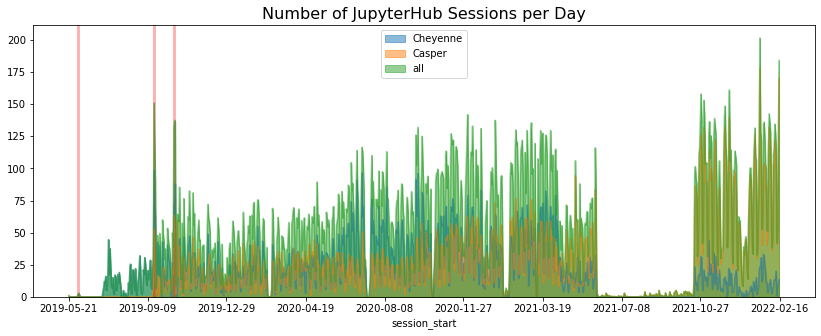

In [13]:
ax = sess_per_day.plot.area(figsize=(14,5), stacked=False)
xticks = np.linspace(0, len(days)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([days[i].strftime('%Y-%m-%d') for i in xticks])
ax.set_title('Number of JupyterHub Sessions per Day', fontsize=16)
for tutorial in tutorials:
    t1, t2 = tutorials[tutorial]
    ax.axvspan(days.get_loc(t1)-1, days.get_loc(t2)+1, facecolor='r', alpha=.3, edgecolor='none')

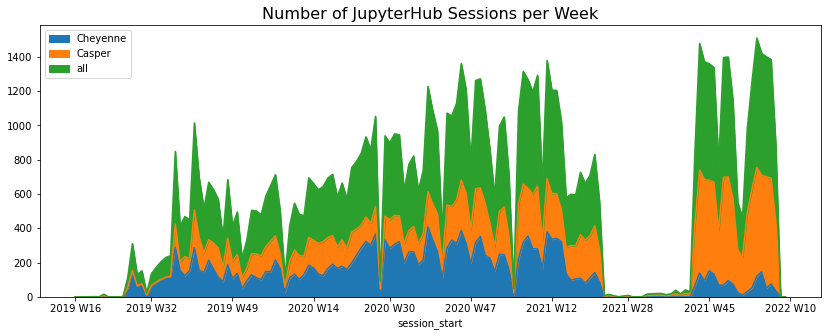

In [14]:
ax = sess_per_wk.plot.area(figsize=(14,5))
xticks = np.linspace(0, len(wks)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([wks[i].strftime('%Y W%U') for i in xticks])
ax.set_title('Number of JupyterHub Sessions per Week', fontsize=16);

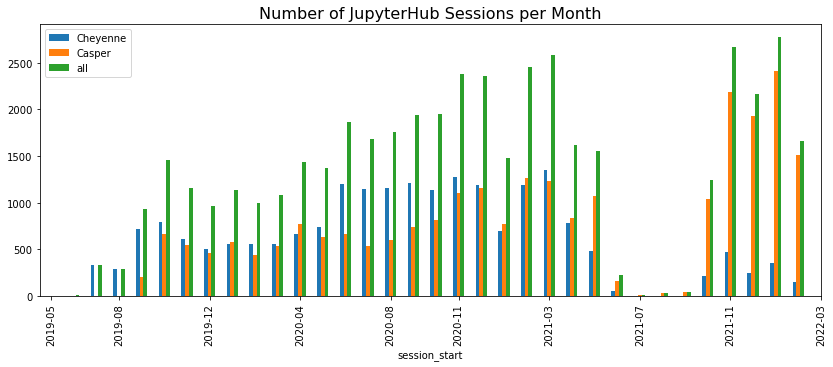

In [15]:
ax = sess_per_mon.plot.bar(figsize=(14,5))
xticks = np.linspace(0, len(mons)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([mons[i].strftime('%Y-%m') for i in xticks])
ax.set_title('Number of JupyterHub Sessions per Month', fontsize=16);

**NOTE:** You can see a definite up-tick in the number of sessions following the September and October tutorials.  During this period of time, from August through October, the average number of sessions per day and month more than doubles.

## Unique Users by Day, Week & Month

Next, we look at the number of unique users per day, week and month.

In [16]:
users_per_day = pd.DataFrame()
users_per_wk = pd.DataFrame()
users_per_mon = pd.DataFrame()
for name in dfs:
    users_per_day[name] = 0.5 * (dfs[name].user.groupby(pd.cut(dfs[name].session_start, days)).nunique() +
                                 dfs[name].user.groupby(pd.cut(dfs[name].session_end, days)).nunique()).rename(f'Unique Users per Day ({name})')
    users_per_wk[name] = 0.5 * (dfs[name].user.groupby(pd.cut(dfs[name].session_start, wks)).nunique() +
                                dfs[name].user.groupby(pd.cut(dfs[name].session_end, wks)).nunique()).rename(f'Unique Users per Week ({name})')
    users_per_mon[name] = 0.5 * (dfs[name].user.groupby(pd.cut(dfs[name].session_start, mons)).nunique() +
                                 dfs[name].user.groupby(pd.cut(dfs[name].session_end, mons)).nunique()).rename(f'Unique Users per Month ({name})')

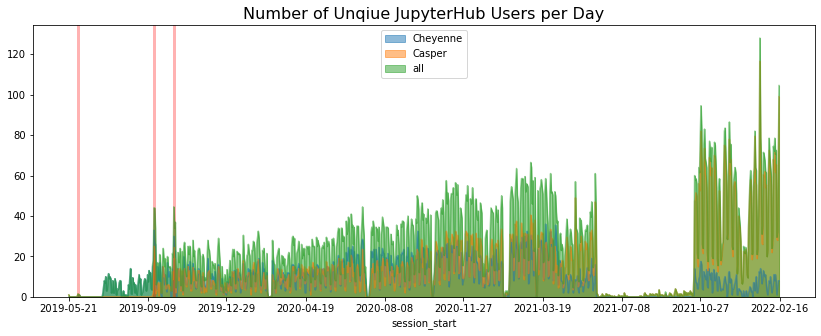

In [17]:
ax = users_per_day.plot.area(figsize=(14,5), stacked=False)
xticks = np.linspace(0, len(days)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([days[i].strftime('%Y-%m-%d') for i in xticks])
ax.set_title('Number of Unqiue JupyterHub Users per Day', fontsize=16)
for tutorial in tutorials:
    t1, t2 = tutorials[tutorial]
    ax.axvspan(days.get_loc(t1)-1, days.get_loc(t2)+1, facecolor='r', alpha=.3, edgecolor='none')

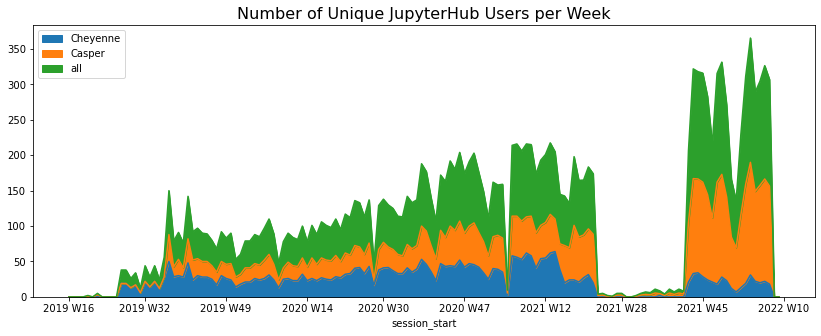

In [18]:
ax = users_per_wk.plot.area(figsize=(14,5))
xticks = np.linspace(0, len(wks)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([wks[i].strftime('%Y W%U') for i in xticks])
ax.set_title('Number of Unique JupyterHub Users per Week', fontsize=16);

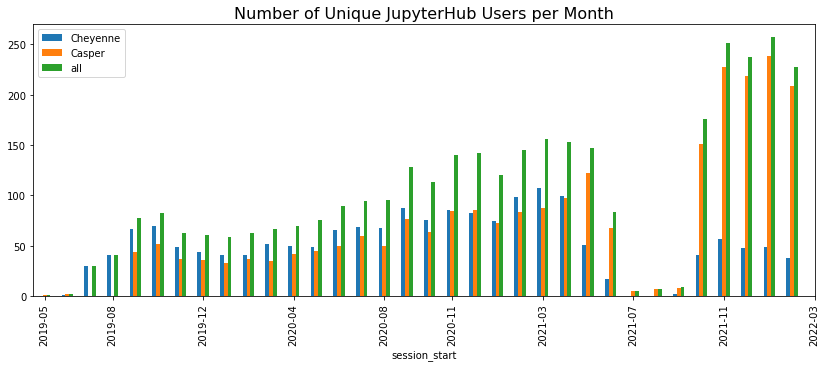

In [19]:
ax = users_per_mon.plot.bar(figsize=(14,5))
xticks = np.linspace(0, len(mons)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([mons[i].strftime('%Y-%m') for i in xticks])
ax.set_title('Number of Unique JupyterHub Users per Month', fontsize=16);

**NOTE:** Again, you can note a growth in users following each tutorial/hackathon (September and October).  

In [20]:
%watermark -iv -d -u

Last updated: 2022-02-16

sys   : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) 
[GCC 9.4.0]
numpy : 1.21.5
pandas: 1.4.0
json  : 2.0.9

